In earlier notebook we discussed about the binary classification, here we are going to discuss about the 'regression', wchis consists of predicting continuous values instead of discrete labels.


We are going to use the Boston housing Price dataset.

In [2]:

import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, ReLU, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import boston_housing

from sklearn.preprocessing import StandardScaler

In [3]:
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

Idea about the dataset, what are the feaures present in the dataset:-

Per capita crime rate.
Proportion of residential land zoned for lots over 25,000 square feet.
Proportion of non-retail business acres per town.
Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
Nitric oxides concentration (parts per 10 million).
Average number of rooms per dwelling.
Proportion of owner-occupied units built prior to 1940.
Weighted distances to five Boston employment centres.
Index of accessibility to radial highways.
Full-value property-tax rate per $10,000.
Pupil-teacher ratio by town.
1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
lower status of the population.

In [4]:
print(len(train_data[0]))
print(train_data[0])

13
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


### Preprocessing of data

1. using scikit learn feature to remove the mean and variance from the data. eature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation

In [5]:
scaler = StandardScaler()
print(scaler.fit(train_data))
train_data = scaler.transform(train_data)

test_data = scaler.transform(test_data)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [6]:
print(train_data[0])

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


In [7]:
def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape = (train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

we can see that we are not using sigmoid in the output layer, as we want it to be the continuous output.

Note that we are compiling the network with the mse loss function: Mean Squared Error, the square of the difference between the predictions and the targets, a widely used loss function for regression problems.

MAE of 0.5 on this problem would mean that our predictions are off by \$500 on average



### Using K-fold approach 

One way we saw in earlier notebook to find overfitting anf underfittig was looking at the validation/training loss and accuracy and then adjusting the epochs based on that. We could split the data in training and validation set but whn we have fewer data points then the validation set is very small. the onsequence is that the validation scores may change a lot depending on what data points did we chose to use for validation. THE VALIDATION SCORE MIGHT HAVE LARGE VARIATION with regard to validaition split. so we cant rely on that.


Here we are going to work on a different approach called K-fold validation. In this the avaliable data is split into K partitions(k=4 or k=5), then instantiating k identical models and training each one on k-1 partiitions while evaluating in reamaining partition. 

In [8]:
print('train_data', train_data.shape)
print('test_data', test_data.shape)
print('train_trarget', train_targets .shape)

train_data (404, 13)
test_data (102, 13)
train_trarget (404,)


In [40]:
k = 4
val_samples = len(train_data) // 4
print('data points in each set: ', val_samples)
num_epochs = 50

all_scores= []

mae_history = []
loss = []
loss_val = []
mae_history_val = []


for i in range(k):
    print('which set are we processing: ', i)
    
    #step1: defining validation dataset
    # in i=0 the first (1/4) data is validation set
    val_data = train_data[i*val_samples: (i+1)*val_samples]
    val_target = train_targets[i*val_samples: (i+1)*val_samples]
    
    # step2: defining training data
    # next step is to prepare the training data
    # for that we are going to concatinate the remaining data
    
    training_data_new = np.concatenate([train_data[:i*val_samples], train_data[(i + 1)*val_samples:]], axis=0)
    training_target_new = np.concatenate([train_targets[:i*val_samples], train_targets[(i + 1)*val_samples: ]], axis=0)
    
    model = build_model()
    history = model.fit(training_data_new, training_target_new, 
                        validation_data=(val_data, val_target),
                        epochs = num_epochs, batch_size=1, verbose=0)
    
    #print(history.history.keys())
    mae_history.append(history.history['mean_absolute_error'])
    mae_history_val.append(history.history['val_mean_absolute_error'])
    loss.append(history.history['loss'])
    loss_val.append(history.history['val_loss'])

data points in each set:  101
which set are we processing:  0
which set are we processing:  1
which set are we processing:  2
which set are we processing:  3


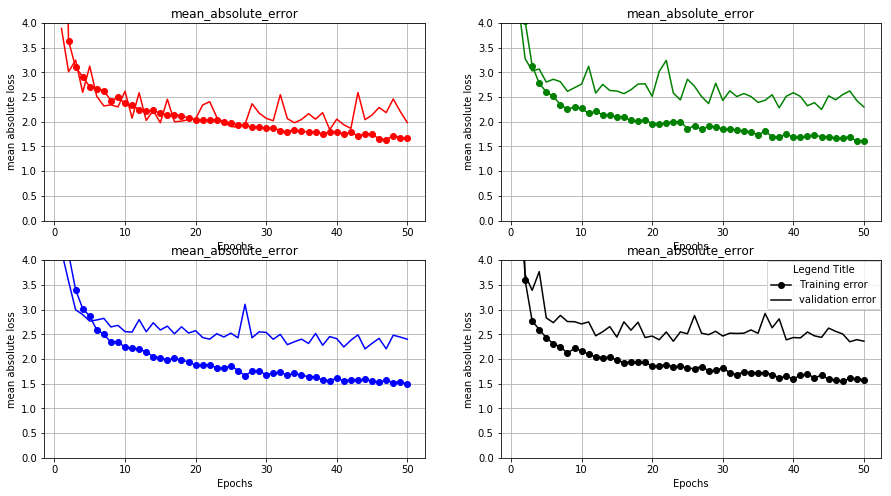

In [56]:
color = ['r', 'g', 'b', 'k']
epochs = range(1, len(all_mae_histories[0]) + 1)
plt.figure(figsize=(15,8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(epochs,mae_history[i], '-o' , color = color[i])
    plt.plot(epochs,mae_history_val[i] , color = color[i])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('mean absolute loss')
    plt.ylim((0,4)) 
    plt.grid()
plt.legend(labels = [ 'Training error', 'validation error'],
           loc="best",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title"  # Title for the legend
           )

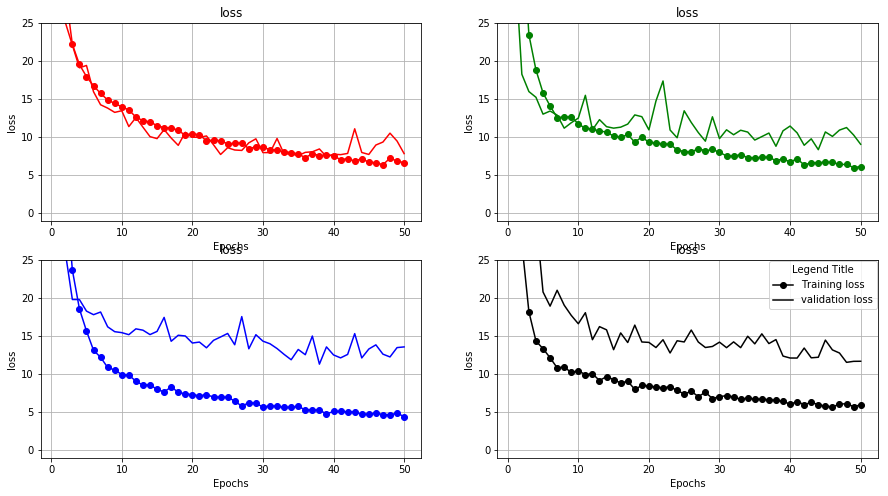

In [55]:
color = ['r', 'g', 'b', 'k']
epochs = range(1, len(all_mae_histories[0]) + 1)
plt.figure(figsize=(15,8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(epochs,loss[i], 'o-' , color = color[i])
    plt.plot(epochs,loss_val[i] , color = color[i])
    plt.title('loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.ylim((-1,25)) 
    plt.grid()
plt.legend(labels = [ 'Training loss', 'validation loss'],
           loc="best",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title"  # Title for the legend
           )

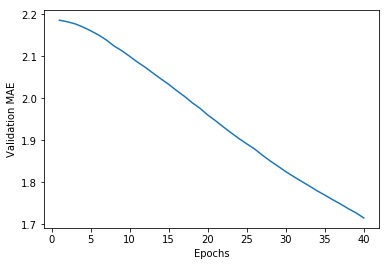

In [59]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## smotthening the curve in 
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()